*10x Genomics* is a biotech company that developed a popular platform for **single-cell sequencing**. Their technology (often called 10x Chromium) allows you to capture and sequence thousands of single cells at once, assigning each cell a barcode so you can track which RNA molecules came from which cell.

When you process raw sequencing data with Cell Ranger, you typically get a folder with files like:
* matrix.mtx: The expression matrix in Matrix Market format (sparse). It contains the counts: rows = genes, columns = cells.
* genes.tsv or features.tsv (depending on Cell Ranger version): A tab-separated file with gene/feature metadata. Typically columns: Gene ID (like ENSG00000123456), Gene name (like TP53), and Feature type (like Gene Expression / Antibody Capture).
* barcodes.tsv: A tab-separated file with cell barcodes (one per line). Each barcode corresponds to a column in matrix.mtx.

The data contains the number of RNA molecules (gene counts) detected in each cell. Each cell’s RNAs are tagged with a unique cell barcode so we know which cell they came from. To avoid counting duplicates, every RNA molecule also gets a unique molecular identifier (UMI). This labeling is done using barcoded gel beads, which are placed with individual cells inside tiny droplets called GEMs using microfluidic devices.


In [1]:
!pip install scanpy
!conda install -y -c anaconda cmake
!pip install leidenalg
!pip install louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.8 MB/s eta 0:00:00
/bin/bash: line 1: conda: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 38.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for louvain: filename=louvain-0.8.2-cp312-cp312-linux_x86_64.whl size=971850 sha256=1824e6859d7b7672d2223098a4213c9d89fbfabb200e8241eb4f42ba47950748
  Stored in directory: /root/.cache/pip/wheel

**Scanpy** is a scalable toolkit for analyzing single-cell gene expression data built jointly with anndata (annotated data). It includes preprocessing, visualization, clustering, trajectory inference and differential expression testing. The Python-based implementation efficiently deals with datasets of more than one million cells. Scanpy assembles the 3 files below into one *AnnData* object using *read_10x_mtx()* method:
* Reads matrix.mtx → becomes .X in the *AnnData* object.
* Reads barcodes.tsv → becomes .obs (rows, i.e. cells).
* Reads genes.tsv / features.tsv → becomes .var (columns, i.e. genes).

Once loaded, you can save as a .h5ad file for convenience. It is the compact all-in-one *AnnData* format recommended for analysis in Scanpy.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
annotated_data = sc.read_10x_mtx(
    f'',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

print(annotated_data) # cells × features (genes) = 800 × 36601

AnnData object with n_obs × n_vars = 800 × 36601
    var: 'gene_ids', 'feature_types'


# **Structure of .X**
.X has one column per gene (feature). The total number of columns = number of unique genes detected in the experiment. Each cell has many genes being expressed at the same time. So according to this structure, a cell contains all genes, but some are highly expressed (big numbers), some weakly (small numbers), some not at all, denoted by 0.

**Expression value of a gene in a cell** refers to how much a gene is *turned on* in that cell. It is the number of RNA molecules detected for that gene in that cell.

In [3]:
print(annotated_data.X.shape)
print(annotated_data.X[0])

(800, 36601)
<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 3095 stored elements and shape (1, 36601)>
  Coords	Values
  (0, 23)	1.0
  (0, 59)	3.0
  (0, 60)	1.0
  (0, 73)	1.0
  (0, 97)	1.0
  (0, 101)	1.0
  (0, 170)	15.0
  (0, 173)	2.0
  (0, 194)	4.0
  (0, 207)	1.0
  (0, 208)	1.0
  (0, 211)	1.0
  (0, 216)	2.0
  (0, 219)	6.0
  (0, 220)	1.0
  (0, 246)	1.0
  (0, 250)	11.0
  (0, 261)	1.0
  (0, 280)	2.0
  (0, 298)	1.0
  (0, 367)	1.0
  (0, 380)	1.0
  (0, 416)	1.0
  (0, 438)	1.0
  (0, 439)	4.0
  :	:
  (0, 36384)	1.0
  (0, 36398)	1.0
  (0, 36400)	1.0
  (0, 36401)	27.0
  (0, 36404)	1.0
  (0, 36406)	1.0
  (0, 36410)	1.0
  (0, 36415)	2.0
  (0, 36429)	2.0
  (0, 36445)	1.0
  (0, 36450)	3.0
  (0, 36492)	1.0
  (0, 36495)	1.0
  (0, 36559)	11.0
  (0, 36560)	7.0
  (0, 36561)	43.0
  (0, 36562)	112.0
  (0, 36563)	8.0
  (0, 36564)	27.0
  (0, 36565)	42.0
  (0, 36566)	47.0
  (0, 36567)	2.0
  (0, 36568)	27.0
  (0, 36569)	2.0
  (0, 36571)	20.0


# **Structure of .obs**
In the experiment, each cell gets a unique barcode sequence (like AAACATACAACCAC-1). These barcodes are stored in .obs as the index (rows). The rows of .X are aligned with .obs.

In [4]:
print(annotated_data.obs.shape)
print(annotated_data.obs.index)

(800, 0)
Index(['AAATGGATCAAGATAG-1_A549-A549', 'AACAAAGTCGGTCGGT-1_A549-A549',
       'AACCATGTCCATTGCC-1_A549-A549', 'AACCTTTGTAAGAACT-1_A549-A549',
       'AAGCATCAGTACAGAT-1_A549-A549', 'AAGCGTTGTTGGGACA-1_A549-A549',
       'AAGGTAAGTCTCCTGT-1_A549-A549', 'ACCAAACTCGCAACAT-1_A549-A549',
       'ACCATTTCAACTGAAA-1_A549-A549', 'ACCGTTCCAATCTCGA-1_A549-A549',
       ...
       'TCCTAATGTGCAATAA-1_PC9-PC9', 'TCGATTTGTCGTGGAA-1_PC9-PC9',
       'TCGGGACCAACAGCCC-1_PC9-PC9', 'TCTCTGGGTGACTCTA-1_PC9-PC9',
       'TCTGTCGTCGGTCTAA-1_PC9-PC9', 'TGCGATATCCACCTCA-1_PC9-PC9',
       'TGCTCGTCATCATCTT-1_PC9-PC9', 'TGGCGTGTCGCAGTCG-1_PC9-PC9',
       'TGTGTGAAGCACTAGG-1_PC9-PC9', 'TTATTGCTCAACGTGT-1_PC9-PC9'],
      dtype='object', length=800)


# **Structure of .var**
.var is a pandas DataFrame that holds annotations for the variables (the columns of .X). It is actually the metadata about genes. In single-cell RNA-seq, variables are usually genes.

Each column in .X = one gene (or other feature), and .var rows correspond exactly to those columns. Therefore, index of .var = gene identifiers (IDs or symbols). In other words:

* .X[:, j] → expression values for gene j across all cells.

* .var.iloc[j] → metadata about gene j.

So if .X says “cell #5 has 7 counts for gene column #100”,
.var tells you “gene column #100 is TP53, ENSG00000141510, protein-coding”.

In [5]:
annotated_data.var

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC141272.1,ENSG00000277836,Gene Expression
AC023491.2,ENSG00000278633,Gene Expression
AC007325.1,ENSG00000276017,Gene Expression
AC007325.4,ENSG00000278817,Gene Expression


In [6]:
annotated_data.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

# **Data Preprocessing**

Excluding undesired cells and genes

In [7]:
sc.pp.filter_cells(annotated_data, min_genes=200) # Exclude cells with fewer than 200 genes
sc.pp.filter_genes(annotated_data, min_cells=3)   # Exclude genes that are found in fewer than 3 cells

print(annotated_data) # cells × features (genes) = 800 × 36601

AnnData object with n_obs × n_vars = 798 × 18155
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'


Add a column to .var structure to show the mitochondrial status of each gene

In [8]:
annotated_data.var['mt'] = annotated_data.var_names.str.startswith('MT-')  # Annotate the group of mitochondrial genes as 'mt'

Exoloring some specific genes in the .var structure

In [9]:
print(annotated_data.var[annotated_data.var.mt == True])

                gene_ids    feature_types  n_cells    mt
MT-ND1   ENSG00000198888  Gene Expression      599  True
MT-ND2   ENSG00000198763  Gene Expression      625  True
MT-CO1   ENSG00000198804  Gene Expression      744  True
MT-CO2   ENSG00000198712  Gene Expression      781  True
MT-ATP8  ENSG00000228253  Gene Expression      540  True
MT-ATP6  ENSG00000198899  Gene Expression      728  True
MT-CO3   ENSG00000198938  Gene Expression      760  True
MT-ND3   ENSG00000198840  Gene Expression      769  True
MT-ND4L  ENSG00000212907  Gene Expression      431  True
MT-ND4   ENSG00000198886  Gene Expression      738  True
MT-ND5   ENSG00000198786  Gene Expression      603  True
MT-ND6   ENSG00000198695  Gene Expression      291  True
MT-CYB   ENSG00000198727  Gene Expression      703  True


*calculate_qc_metrics()* **method:** Calculates a number of Quality Control metrics for an AnnData object. Currently is most efficient on a sparse CSR or dense matrix. That this method can take a while to compile on the first call. That result is then cached to disk to be used later. Running this method will add some statistics to the observations.

In [10]:
sc.pp.calculate_qc_metrics(annotated_data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
annotated_data.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAATGGATCAAGATAG-1_A549-A549,3095,3072,8455.0,348.0,4.115908
AACAAAGTCGGTCGGT-1_A549-A549,2376,2364,6457.0,329.0,5.095245
AACCATGTCCATTGCC-1_A549-A549,4172,4144,14749.0,480.0,3.254458
AACCTTTGTAAGAACT-1_A549-A549,1876,1868,4215.0,69.0,1.637011
AAGCATCAGTACAGAT-1_A549-A549,1666,1664,4153.0,79.0,1.902239
...,...,...,...,...,...
TGCGATATCCACCTCA-1_PC9-PC9,3293,3289,10780.0,211.0,1.957328
TGCTCGTCATCATCTT-1_PC9-PC9,2758,2751,7829.0,155.0,1.979819
TGGCGTGTCGCAGTCG-1_PC9-PC9,2100,2099,5978.0,163.0,2.726664
TGTGTGAAGCACTAGG-1_PC9-PC9,3359,3351,10033.0,218.0,2.172830


*sc.pl.violin(...)* command generates violin plots to visualize the distribution of key quality control metrics across all cells in the *annotated_data* object:
* n_genes_by_counts: The number of genes detected per cell. This metric shows the number of different genes for which at least one RNA molecule (UMI) was detected in a given cell. It's a measure of the diversity of genes expressed in a cell. A cell with a high *n_genes_by_counts* is expressing a wide variety of genes, while a cell with a low value might be of lower quality or a less complex cell type.
* total_counts: The total number of UMI counts (total expression) per cell. This metric shows the total number of RNA molecules (UMIs) detected in a given cell across all genes. It's a measure of the total amount of RNA captured and sequenced for that cell, often referred to as the library size. A cell with high *total_counts* has a larger library, meaning more RNA molecules were sequenced from it.
* pct_counts_mt: The percentage of counts that come from mitochondrial genes per cell. Mitochondrial genes are genes encoded by the mitochondria, which are organelles within the cell responsible for energy production. In single-cell RNA sequencing, a high percentage of reads mapping to mitochondrial genes can indicate that a cell is of poor quality or stressed. Therefore, pct_counts_mt is a key quality control metric used to identify and filter out low-quality or stressed cells. Cells with a high pct_counts_mt are often considered to be compromised and are typically removed from the dataset to avoid downstream analysis being skewed by these poor-quality profiles.

We can assess the quality of single-cell data and identify potential outliers. Other arguments of the violin method are:
* jitter=0.4: This adds jitter to the data points within each violin plot. Jitter helps visualize the individual data points and their density, especially when there are many overlapping points. A value of 0.4 controls the amount of jitter.
* multi_panel=True: This argument tells scanpy to create multiple violin plots, one for each variable specified in the list, and display them side-by-side in a single figure.

The x-axis in each individual violin plot within the multi-panel figure represents the different cells in the dataset. The violin shape itself shows the distribution of the respective metric for all cells.

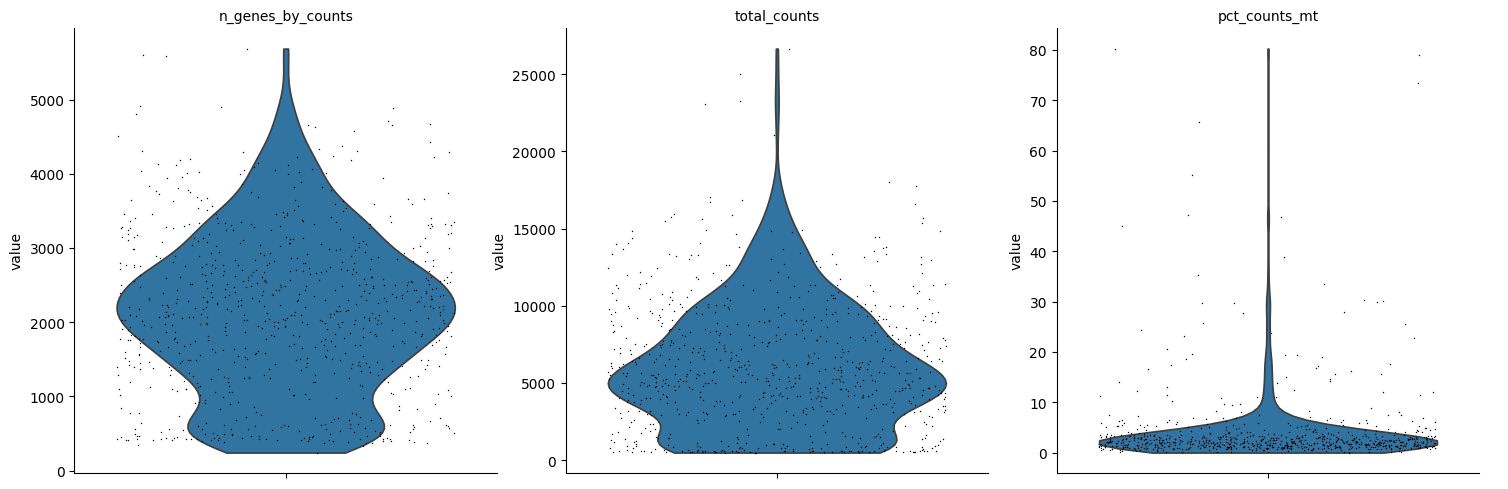

In [11]:
sc.pl.violin(annotated_data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

**Visualization of the Relationships between Key Quality Control Metrics**

This plot shows the relationship between the total amount of RNA captured per cell (total_counts) and the proportion of that RNA that comes from mitochondrial genes (pct_counts_mt). A high percentage of mitochondrial counts often indicates stressed or dying cells. By plotting this against the total counts, you can see if cells with low total counts also tend to have a higher percentage of mitochondrial counts. This would suggest that cells with less captured RNA are also more likely to be of poor quality. Conversely, cells with high total counts but also high mitochondrial percentages might also be problematic. This plot helps to set thresholds for filtering out cells that are likely compromised.

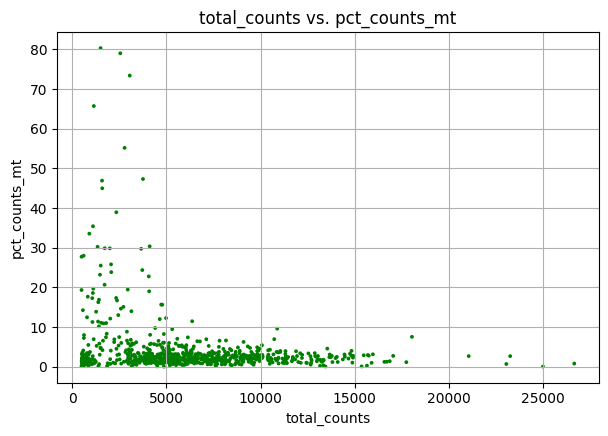

In [12]:
ax1 = sc.pl.scatter(annotated_data, x='total_counts', y='pct_counts_mt', color='green', size=30, show=False)
ax1.grid(True)
ax1.set_title('total_counts vs. pct_counts_mt')
ax1.set_xlabel('total_counts')
ax1.set_ylabel('pct_counts_mt')
ax1.figure.show()

This plot visualizes the relationship between the total amount of RNA captured per cell (total_counts) and the number of different genes detected in that cell (n_genes_by_counts). Generally, we expect a positive correlation between these two metrics. Cells with more total RNA captured (higher total_counts) should also have a greater diversity of genes detected (higher n_genes_by_counts). Deviations from this trend can indicate issues. For example:

* Cells with high total counts but low gene counts might suggest contamination or a problem with gene detection.
* Cells with low total counts but relatively high gene counts might be less common but could still be valid cells.
* Cells with very low values for both metrics are likely low-quality or empty droplets. This plot helps you identify cells that fall outside the expected relationship and might need further investigation or filtering.


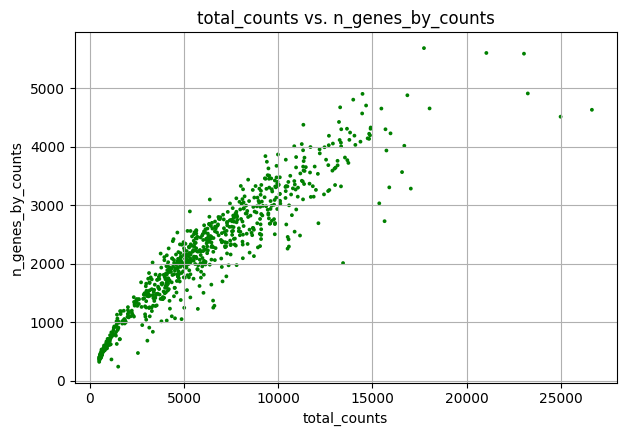

In [13]:
ax2 = sc.pl.scatter(annotated_data, x='total_counts', y='n_genes_by_counts', color='green', size=30, show=False)
ax2.grid(True)
ax2.set_title('total_counts vs. n_genes_by_counts')
ax2.set_xlabel('total_counts')
ax2.set_ylabel('n_genes_by_counts')
ax2.figure.show()

Accessing to the features of a specific cell

In [14]:
annotated_data[annotated_data.obs.index == 'AAATGGATCAAGATAG-1_A549-A549']

View of AnnData object with n_obs × n_vars = 1 × 18155
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

By using quantiles (specifically the 2nd and 98th percentiles in this case), we can remove the extreme outliers from the distribution of gene counts. Cells with extremely low gene counts might be empty droplets or very low-quality captures, while cells with extremely high gene counts could be doublets (two cells captured together). Using quantiles provides a data-driven way to define these thresholds. Therefore, we can implement a robust quality control strategy by removing cells at the extreme ends of the distribution for gene counts and those with a high burden of mitochondrial reads, which are both indicators of potentially problematic cells.

407.0 to 4331.819999999998


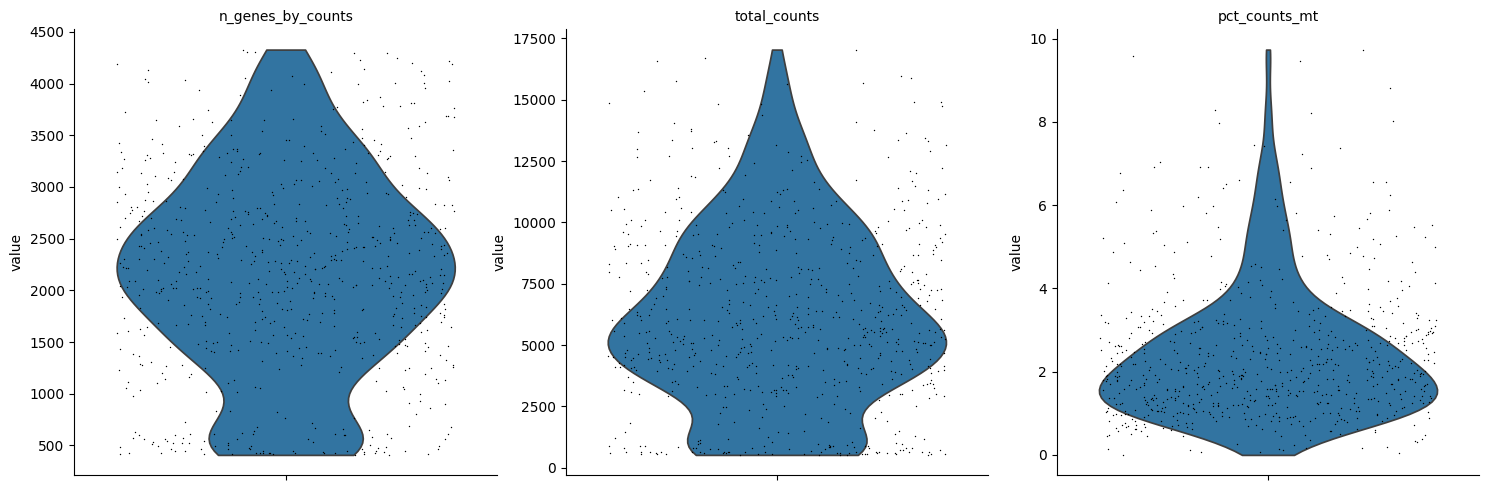

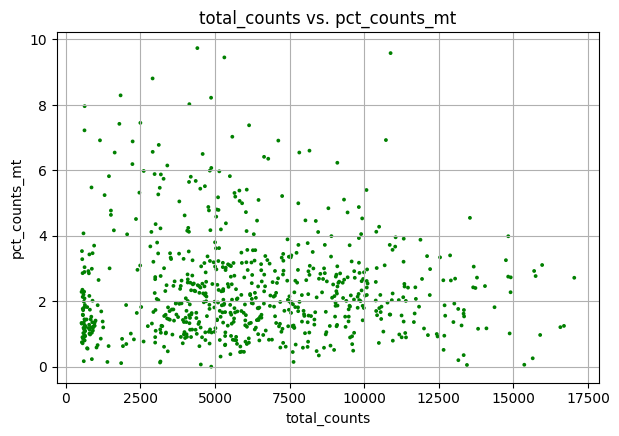

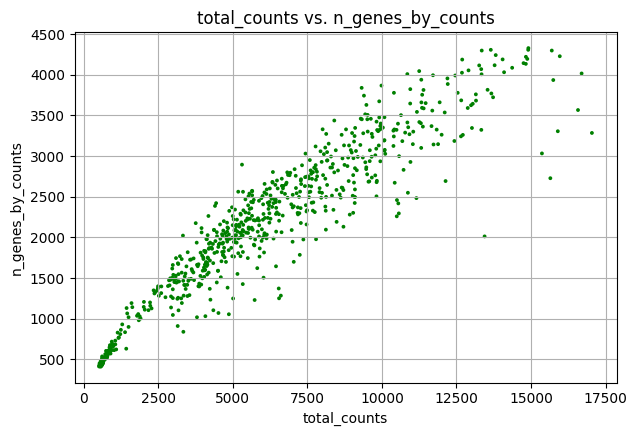

In [15]:
upper_lim = np.quantile(annotated_data.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(annotated_data.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

annotated_data = annotated_data[(annotated_data.obs.n_genes_by_counts < upper_lim) & (annotated_data.obs.n_genes_by_counts > lower_lim)]
annotated_data = annotated_data[annotated_data.obs.pct_counts_mt < 10]

sc.pl.violin(annotated_data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

ax1 = sc.pl.scatter(annotated_data, x='total_counts', y='pct_counts_mt', color='green', size=30, show=False)
ax1.grid(True)
ax1.set_title('total_counts vs. pct_counts_mt')
ax1.set_xlabel('total_counts')
ax1.set_ylabel('pct_counts_mt')
ax1.figure.show()

ax2 = sc.pl.scatter(annotated_data, x='total_counts', y='n_genes_by_counts', color='green', size=30, show=False)
ax2.grid(True)
ax2.set_title('total_counts vs. n_genes_by_counts')
ax2.set_xlabel('total_counts')
ax2.set_ylabel('n_genes_by_counts')
ax2.figure.show()

We can access to the raw data by X

In [16]:
annotated_data.X # Shows the number of stored elements and the shape

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 1548155 stored elements and shape (714, 18155)>

This command extracts the gene expression values for the first cell in the dataset across all genes. The output is a representation of all the expression counts for that single cell. This is about accessing the expression profile of a single cell. We are retrieving the individual expression level for every gene within that cell. It's a vector of numbers, where each number is the count for a specific gene.

In [17]:
annotated_data.X[0,:] # Shows the number of all genes of the first cell

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 3072 stored elements and shape (1, 18155)>

This is about calculating a summary statistic for a single cell. The sum of all gene expression counts for a cell is equivalent to the total UMI counts or the library size for that cell. It shows the total number of RNA molecules that were detected and counted in that specific cell, regardless of which gene they came from.

In [18]:
annotated_data.X[0,:].sum()

np.float32(8455.0)

**Normalization**


The sc.pp.normalize_total function normalizes each cell's total counts to a specified target_sum. This is a crucial step in single-cell RNA sequencing analysis because it helps to account for differences in library size between cells. If we didn't normalize, cells with more total RNA captured would naturally have higher counts for all their genes, which could be misinterpreted as higher expression levels rather than just a technical artifact of sequencing depth.

The target_sum is the value we want the total counts of each cell to be after normalization. A common choice for target_sum is 10,000 (1e4). This value is often used because it scales the counts to a range that is somewhat comparable to older bulk RNA sequencing data, where counts were sometimes expressed as "reads per 10,000 reads".

In [19]:
sc.pp.normalize_total(annotated_data, target_sum=10000) #normalize every cell to 10,000 UMI
annotated_data.X[0,:].sum() # Test the normalization

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


np.float32(10000.0)

 This command is used to apply a log transformation to the gene expression data. Specifically, it applies the function log(1 + x) to each value in the expression matrix (annotated_data.X).

The log1p transformation is a standard preprocessing step in single-cell RNA sequencing analysis that helps to address the characteristics of the data (sparsity, mean-variance relationship, skewed distribution) and make it more suitable for downstream computational analysis and visualization. It effectively "smooths out" the data and makes differences in lower expression values more prominent.

In [20]:
sc.pp.log1p(annotated_data) # change to log counts
print(annotated_data.X[0,:].sum())

3409.9844


To visualize the effect of the sc.pp.log1p transformation, you can plot the distribution of gene expression values before and after applying the transformation. Since the log1p transformation changes the values in annotated_data.X, we can plot the distribution of values in this matrix before and after the transformation. For demonstration, we can sample a subset of the data or plot the distribution of counts for a specific gene across cells. Plotting the distribution of all values in the matrix might be too dense, so we plot the distribution of total counts per cell before and after transformation as an example.

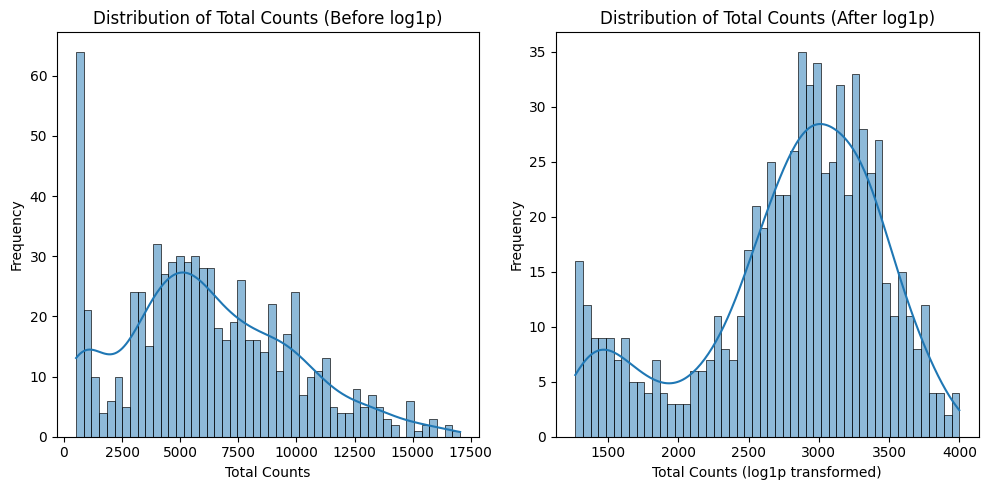

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total counts per cell after log1p transformation
annotated_data.obs['total_counts_log1p'] = annotated_data.X.sum(axis=1).A1

# Plot histograms of total counts before and after log1p transformation
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(annotated_data.obs['total_counts'], bins=50, kde=True)
plt.title('Distribution of Total Counts (Before log1p)')
plt.xlabel('Total Counts')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(annotated_data.obs['total_counts_log1p'], bins=50, kde=True)
plt.title('Distribution of Total Counts (After log1p)')
plt.xlabel('Total Counts (log1p transformed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()